<img src='./img/header_placeholder.png' alt='Logo EU Copernicus ECMWF' align='right' width='100%'></img>

# CAMS Dust monitoring

### About

This notebook provides you a practical introduction to the [CAMS European air quality forecasts](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview) and [CAMS global atmospheric composition forecasts](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-atmospheric-composition-forecasts?tab=overview) data sets. We will use both datasets to analyse a Saharan dust event that impacted Europe (primarily parts of Spain and France) between 21 to 23 February 2021. 

The notebook has three main sections with the following outline:

* [1 - Define a discrete, not continuous color scale used in CAMS](#cams_colormap)
* [2 - CAMS European air quality forecasts](#europe_aq_forecast)
  * [2.1 - Load and browse CAMS European air quality forecasts](#eur_aq_load_browse)
  * [2.2 - Select and plot a map of dust over Europe in February 2021](#dust_map)
  * [2.3 - Select and plot a map of PM10 over Europe in February 2021](#pm10_map)
* [3 - CAMS global atmospheric composition forecasts](#global_aq_forecast)
  * [3.1 - Unzip the downloaded data file](#cams_forecast_unzip)
  * [3.2 - Load and browse CAMS global forecast of total Aerosol Optical Depth at 550nm](#load_browse_aod)
  * [3.3 - Visualize a global map of total AOD at 550nm in February 2021](#visualize_global_aod)

### Data

This notebook introduces you to the `CAMS European air quality forecasts` and the `CAMS global atmospheric composition forecasts`. The data has the following specifications:

> **Data**: `CAMS European air quality forecasts` <br>
> **Variables**: `Dust`, `Particulate Matter 10` <br>
> **Type**: `Analysis` <br>
> **Temporal coverage**: `20-25 February 2021` <br>
> **Temporal resolution**: `hourly` <br>
> **Spatial coverage**: `Europe` <br>
> **Format**: `NetCDF`<br>
> **Retrieve request**: [CDS API request](./200_atmosphere_data_store_intro.ipynb#europe_air_quality)

<br>

> **Data**: `CAMS global atmospheric composition forecasts` <br>
> **Variables**: `Total Aerosol Optical Depth 550` <br>
> **Type**: `Forecast` <br>
> **Temporal coverage**: `20 February 2021` <br>
> **Leadtime hour**: `0 to 90` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `NetCDF`<br>
> **Retrieve request**: [CDS API request](./100_climate_data_store_intro.ipynb#era5_monthly)

Get [here](./201_cams_data_intro.ipynb) more information about CAMS data in general including an overview of the different dataset types.

### How to access the notebook
* via [nbviewer](https://github.com/ecmwf-projects/copernicus-training/blob/master/111_c3s_climatologies_anomalies.ipynb): view a static version of the notebook 
* via [Binder](https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training/HEAD?urlpath=lab/tree/111_c3s_climatologies_anomalies.ipynb): run, execute and modify the notebook

### Further resources

* [Saharan dust events in the spring of 2021 | ECMWF Newsletter Number 168](https://www.ecmwf.int/en/newsletter/168/news/saharan-dust-events-spring-2021)

<hr>

### Load libraries

In [16]:
# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

<hr>

## <a id='cams_colormap'></a>1. Define a discrete, not continuous color scale used in CAMS

The colour map typically used in CAMS is a discrete, not continuous, colour scale. Each row in 'matrix' corresponds to one of the 14 colours in the scale, and each of the three columns corresponds to red, green and blue, respectively. The numbers range from 0 (black) to 256 (white).

For this plot, we may want to create a customised colourmap similar to that used in CAMS products. This is optional however, as there are many default colourmaps that can be used, which are listed here: https://matplotlib.org/stable/gallery/color/colormap_reference.html.

In [18]:
matrix = np.array([[210, 214, 234],
                   [167, 174, 214],
                   [135, 145, 190],
                   [162, 167, 144],
                   [189, 188, 101],
                   [215, 209, 57],
                   [242, 230, 11],
                   [243, 197, 10],
                   [245, 164, 8],
                   [247, 131, 6],
                   [248, 98, 5],
                   [250, 65, 3],
                   [252, 32, 1],
                   [254, 0, 0]])

# Each of the 14 colours in the colourmap will be multiplied by n to create a final
# colourmap of 14*18+1=253 listed colours. The addition of 1 is just to create a starting
# colour of white.
n = 18

# 'cams' is an initial empty colourmap, to be filled by the colours provided in 'matrix'.
cams = np.ones((253, 4))

# This loop fills in the empty 'cams' colourmap with each of the 14 colours in 'matrix'
# multiplied by 'n', with the first row left as 1 (white). Note that each colour value is 
# divided by 256 to normalise the colour range from 0 (black) to 1 (white). 
for i in range(matrix.shape[0]):
    cams[((i*n)+1):(((i+1)*n)+1),:] = np.array([matrix[i,0]/256, matrix[i,1]/256, matrix[i,2]/256, 1])

# The final colourmap is given by 'camscmp', which uses the Matplotlib class 'ListedColormap(Colormap)'
# to generate a colourmap object from the list of colours provided by 'cams'.
camscmp = ListedColormap(cams)

<br>

## <a id='europe_aq_forecast'></a>2. CAMS European air quality forecasts

### <a id='eur_aq_load_browse'></a> 2.1 Load and browse CAMS European air quality forecasts


In [6]:
ds_eur_aq = xr.open_dataset('./data/cams/20210220-25_eur_aq_analysis_dust_pm10.nc')
ds_eur_aq

<xarray.Dataset>
Dimensions:    (latitude: 420, level: 1, longitude: 700, time: 144)
Coordinates:
  * longitude  (longitude) float32 335.0 335.1 335.2 335.4 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * level      (level) float32 0.0
  * time       (time) timedelta64[ns] 00:00:00 01:00:00 ... 5 days 23:00:00
Data variables:
    dust       (time, level, latitude, longitude) float32 ...
    pm10_conc  (time, level, latitude, longitude) float32 ...
Attributes:
    title:        Dust/PM10 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20210220-20210225+[0H_23H]
    summary:      ENSEMBLE model hourly ANALYSIS of Dust/PM10 concentration a...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

<br>

### <a id='dust_map'></a> 2.2 Select and plot a map of dust over Europe in February 2021


In [23]:
# Create a data array of just the dust data:
dust = ds_aq['dust']
# as there is only one level and one time, we can remove
# these by dropping all coordinates with only one entry
dust = dust.squeeze(drop=True)
dust

<xarray.DataArray 'dust' (time: 144, latitude: 420, longitude: 700)>
[42336000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 335.0 335.1 335.2 335.4 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * time       (time) timedelta64[ns] 00:00:00 01:00:00 ... 5 days 23:00:00
Attributes:
    species:        Dust
    units:          µg/m3
    value:          hourly values
    standard_name:  mass_concentration_of_dust_in_air

<br>

Now we can plot the data with the customised colourmap we have created.

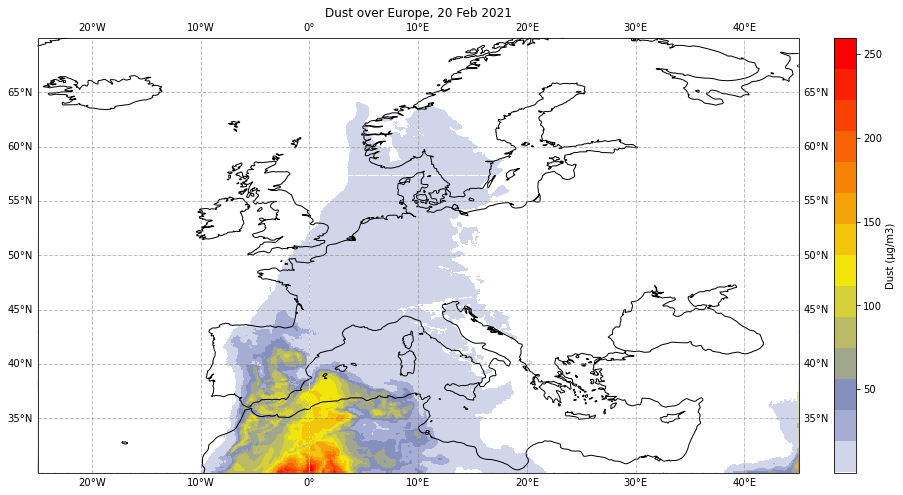

In [39]:
fig = plt.figure(figsize=(16,8))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

ax.coastlines(color='black')
ax.set_extent([-25,45,30,70], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_title('Dust over Europe, 20 Feb 2021', fontsize=12)


im = plt.pcolormesh(dust['longitude'].values, dust['latitude'].values,
                    dust[30,:,:], cmap=camscmp, transform=ccrs.PlateCarree())

cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('Dust (µg/m3)')

<br>

### <a id='pm10_map'></a> 2.3. Select and plot a map of PM10 over Europe in February 2021

Let us now compare this with a map of the other variable: PM10

In [36]:
pm10 = ds_aq['pm10_conc']
pm10 = pm10.squeeze(drop=True)
pm10

<xarray.DataArray 'pm10_conc' (time: 144, latitude: 420, longitude: 700)>
[42336000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 335.0 335.1 335.2 335.4 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * time       (time) timedelta64[ns] 00:00:00 01:00:00 ... 5 days 23:00:00
Attributes:
    species:        PM10 Aerosol
    units:          µg/m3
    value:          hourly values
    standard_name:  mass_concentration_of_pm10_ambient_aerosol_in_air

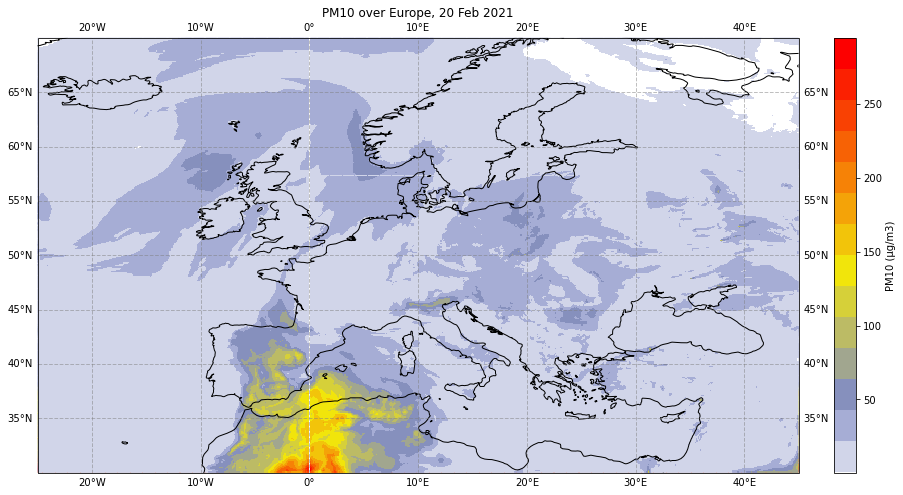

In [35]:
fig = plt.figure(figsize=(16,8))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ax.coastlines(color='black')
ax.set_extent([-25,45,30,70], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_title('PM10 over Europe, 20 Feb 2021', fontsize=12)
im = plt.pcolormesh(pm10['longitude'].values, pm10['latitude'].values,
                    pm10[30,:,:], cmap=camscmp, transform=ccrs.PlateCarree())
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('PM10 (µg/m3)')

<br>

## <a id='global_aq_forecast'></a>3. CAMS global atmospheric composition forecast

### <a id='cams_forecast_unzip'></a> 3.1 Unzip the downloaded data file

In [7]:
import zipfile
with zipfile.ZipFile('./data/cams/20210220_cams_global_forecast_aod.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/cams/')

<br>

### <a id='load_browse_aod'></a> 3.2 Load and browse CAMS global forecast of total Aerosol Optical Depth at 550nm

In [8]:
ds_global_aod = xr.open_dataset('./data/cams/data.nc')
ds_global_aod

<xarray.Dataset>
Dimensions:    (latitude: 451, longitude: 900, time: 31)
Coordinates:
  * longitude  (longitude) float32 0.0 0.4 0.8 1.2 ... 358.4 358.8 359.2 359.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2021-02-20 ... 2021-02-23T18:00:00
Data variables:
    aod550     (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-11-03 05:34:39 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

Notice how there are 14 time steps in the dataset corresponding to the days in February up to 5 days ago.

In [10]:
# Create xarray dataset
aod550 = ds_global_aod['aod550']
aod550

<xarray.DataArray 'aod550' (time: 31, latitude: 451, longitude: 900)>
[12582900 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.4 0.8 1.2 ... 358.4 358.8 359.2 359.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2021-02-20 ... 2021-02-23T18:00:00
Attributes:
    units:      ~
    long_name:  Total Aerosol Optical Depth at 550nm

### <a id='visualize_global_aod'></a> 3.3 Visualize a global map of total AOD at 550nm in February 2021


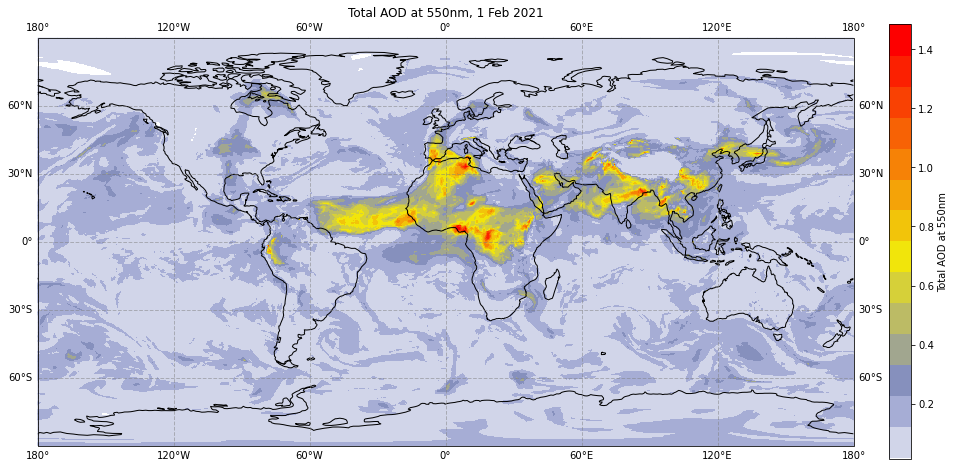

In [37]:
fig = plt.figure(figsize=(16,8))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ax.coastlines(color='black')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_title('Total AOD at 550nm, 1 Feb 2021', fontsize=12)
im = plt.pcolormesh(aod550.longitude, aod550.latitude, aod550[10,:,:],
                    cmap=camscmp, transform=ccrs.PlateCarree())
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('Total AOD at 550nm')

<br>

<hr>

<p><img src='./img/copernicus_logo.png' align='right' alt='Logo EU Copernicus' width='20%'></img></p>
<br><br><br><br><br>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>